# Predicting glioma grading of LGG or GBM using clinical, molecular and mutation features

This jupyter notebooks predicts critical features affecting glioma grading using a Random Forest model, and then trains and evaluates multiple classification models (Logistic Regression, Random Forest, SVM) to predict glioma grade (LGG or GBM).  A summary of findings and insights in pdf format is generated.

## Google colab

You may run this notebook on Google Colab by clicking the "Open in Colab" badge below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenBioResearch/disease-focused-uci-ml-repos/blob/main/uci_glioma_grading_prediction.ipynb)


In [2]:
# Install the ucimlrepo library to fetch the glioma dataset
!pip install ucimlrepo

# Fetch the glioma dataset from the UCI Machine Learning Repository
from ucimlrepo import fetch_ucirepo

glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759)

# pandas dataframes
X = glioma_grading_clinical_and_mutation_features.data.features
y = glioma_grading_clinical_and_mutation_features.data.targets

print(glioma_grading_clinical_and_mutation_features.metadata)
print(glioma_grading_clinical_and_mutation_features.variables)

{'uci_id': 759, 'name': 'Glioma Grading Clinical and Mutation Features', 'repository_url': 'https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/759/data.csv', 'abstract': 'Gliomas are the most common primary tumors of the brain. They can be graded as LGG (Lower-Grade Glioma) or GBM (Glioblastoma Multiforme) depending on the histological/imaging criteria. Clinical and molecular/mutation factors are also very crucial for the grading process. Molecular tests are expensive to help accurately diagnose glioma patients.    In this dataset, the most frequently mutated 20 genes and 3 clinical features are considered from TCGA-LGG and TCGA-GBM brain glioma projects.  The prediction task is to determine whether a patient is LGG or GBM with a given clinical and molecular/mutation features. The main objective is to find the optimal subset of mutation genes and clinical features for the glioma grading 

In [3]:
# Explore the dataset to understand its structure and content
import pandas as pd

# Display the first few rows of the features dataframe
print("Features:")
print(X.head())

# Display the first few rows of the target dataframe
print("\nTargets:")
print(y.head())

# Check for missing values in the dataset
print("\nMissing values in features:")
print(X.isnull().sum())

print("\nMissing values in targets:")
print(y.isnull().sum())

# Replace missing values in numeric columns with the mean of the column
for column in X.select_dtypes(include=['number']).columns:
    X[column].fillna(X[column].mean(), inplace=True)

# Replace missing values in non-numeric columns with the mode of the column
for column in X.select_dtypes(exclude=['number']).columns:
    X[column].fillna(X[column].mode()[0], inplace=True)

# Handle missing values in the target variable 'y' if it's numeric
if y.dtypes['Grade'] in ['int64', 'float64']:
    y.fillna(y.mean(), inplace=True)


Features:
   Gender  Age_at_diagnosis   Race  IDH1  TP53  ATRX  PTEN  EGFR  CIC  MUC16  \
0       0             51.30  white     1     0     0     0     0    0      0   
1       0             38.72  white     1     0     0     0     0    1      0   
2       0             35.17  white     1     1     1     0     0    0      0   
3       1             32.78  white     1     1     1     0     0    0      1   
4       0             31.51  white     1     1     1     0     0    0      0   

   ...  FUBP1  RB1  NOTCH1  BCOR  CSMD3  SMARCA4  GRIN2A  IDH2  FAT4  PDGFRA  
0  ...      1    0       0     0      0        0       0     0     0       0  
1  ...      0    0       0     0      0        0       0     0     0       0  
2  ...      0    0       0     0      0        0       0     0     0       0  
3  ...      0    0       0     0      0        0       0     0     1       0  
4  ...      0    0       0     0      0        0       0     0     0       0  

[5 rows x 23 columns]

Targets:
  

/tmp/ipykernel_23327/1620598184.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[column].fillna(X[column].mean(), inplace=True)
/tmp/ipykernel_23327/1620598184.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(X[column].mean(), inplace=True)
/tmp/ipykernel_23327/1620598184.py:25: FutureWarning: A value is trying to be

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the train and test sets
print(f"Training set shape (features): {X_train.shape}")
print(f"Training set shape (target): {y_train.shape}")
print(f"Testing set shape (features): {X_test.shape}")
print(f"Testing set shape (target): {y_test.shape}")

Training set shape (features): (671, 23)
Training set shape (target): (671, 1)
Testing set shape (features): (168, 23)
Testing set shape (target): (168, 1)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode categorical features
for column in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train.values.ravel())

# Get feature importances
importances = rf.feature_importances_

# Sort features by their importance
indices = np.argsort(importances)[::-1]

# Select the top 20 features
selected_features = X_train.columns[indices][:20]

# Display the selected features
print("Top 20 selected features:")
print(selected_features)


Top 20 selected features:
Index(['Age_at_diagnosis', 'IDH1', 'PTEN', 'CIC', 'ATRX', 'Race', 'IDH2',
       'EGFR', 'TP53', 'Gender', 'PIK3CA', 'NF1', 'MUC16', 'RB1', 'NOTCH1',
       'PIK3R1', 'PDGFRA', 'FUBP1', 'GRIN2A', 'BCOR'],
      dtype='object')


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train[selected_features], y_train.values.ravel())

    # Make predictions
    y_pred = model.predict(X_test[selected_features])
    y_prob = model.predict_proba(X_test[selected_features])[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f'=== {name} ===')
    print(f'Accuracy: {accuracy}')
    print(f'ROC-AUC: {roc_auc}')
    print('Classification Report:')
    print(report)
    print('\n')


=== Logistic Regression ===
Accuracy: 0.8690476190476191
ROC-AUC: 0.9048499502204523
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        89
           1       0.82      0.92      0.87        79

    accuracy                           0.87       168
   macro avg       0.87      0.87      0.87       168
weighted avg       0.88      0.87      0.87       168



=== Random Forest ===
Accuracy: 0.8214285714285714
ROC-AUC: 0.8896316313468924
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        89
           1       0.80      0.84      0.81        79

    accuracy                           0.82       168
   macro avg       0.82      0.82      0.82       168
weighted avg       0.82      0.82      0.82       168



=== SVM ===
Accuracy: 0.7380952380952381
ROC-AUC: 0.8418432655383302
Classification Report:
              precision    recall  f1-sc

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F  # Add this import

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train[selected_features].values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test[selected_features].values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.ravel(), dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture with regularization
class RegularizedNN(nn.Module):
    def __init__(self, input_size):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model, loss function, and optimizer
model = RegularizedNN(input_size=len(selected_features))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adding weight decay

# Training loop with early stopping
num_epochs = 50
best_val_loss = float('inf')
patience, trials = 5, 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trials = 0
    else:
        trials += 1

    if trials >= patience:
        print(f'Early stopping on epoch {epoch+1}')
        break

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = (outputs.numpy().squeeze() > 0.5).astype(int)
    accuracy = accuracy_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, outputs.numpy().squeeze())
    report = classification_report(y_test, predictions)

    print('=== Neural Network ===')
    print(f'Accuracy: {accuracy}')
    print(f'ROC-AUC: {roc_auc}')
    print('Classification Report:')
    print(report)


Epoch 1/50, Training Loss: 1.2060919006665547, Validation Loss: 0.7045691510041555
Epoch 2/50, Training Loss: 1.0254856064206077, Validation Loss: 0.691314309835434
Epoch 3/50, Training Loss: 0.9166840229715619, Validation Loss: 0.6776822110017141
Epoch 4/50, Training Loss: 0.8604263634908766, Validation Loss: 0.6325355569521586
Epoch 5/50, Training Loss: 0.7386091096060616, Validation Loss: 0.6187946299711863
Epoch 6/50, Training Loss: 0.6694467238017491, Validation Loss: 0.6135900616645813
Epoch 7/50, Training Loss: 0.6786005468595595, Validation Loss: 0.5732684632142385
Epoch 8/50, Training Loss: 0.6175737778345743, Validation Loss: 0.560470829407374
Epoch 9/50, Training Loss: 0.586294507696515, Validation Loss: 0.5360541840394338
Epoch 10/50, Training Loss: 0.5619106434640431, Validation Loss: 0.5194078286488851
Epoch 11/50, Training Loss: 0.5239654793625786, Validation Loss: 0.48124343156814575
Epoch 12/50, Training Loss: 0.5190748047261011, Validation Loss: 0.46301887929439545
Ep

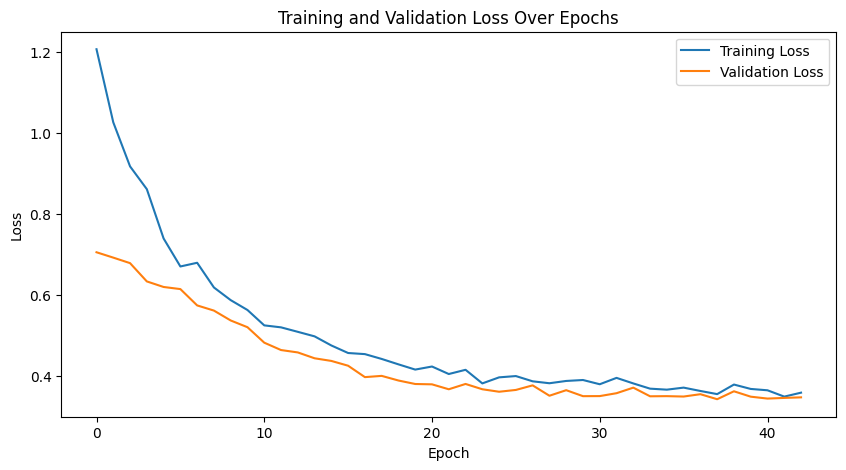

In [10]:
import matplotlib.pyplot as plt  # Ensure this is imported

# Assuming train_losses and val_losses are lists containing loss values for each epoch
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

# Plot the training and validation losses
plot_loss(train_losses, val_losses)


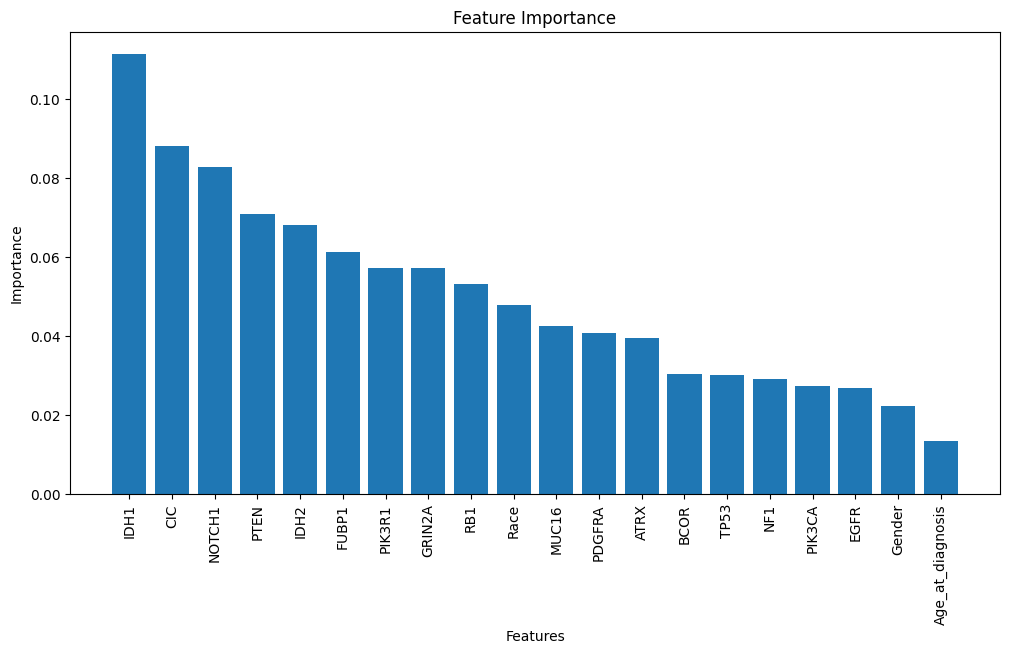

In [11]:
import numpy as np

# Function to calculate and plot feature importance
def plot_feature_importance(model, feature_names):
    # Extract the weights from the first fully connected layer
    fc1_weights = model.fc1.weight.cpu().detach().numpy()

    # Calculate the absolute sum of weights for each feature
    feature_importance = np.sum(np.abs(fc1_weights), axis=0)

    # Normalize the importance values
    feature_importance = feature_importance / np.sum(feature_importance)

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)
    plt.show()

# Plot the feature importance
feature_names = X_train[selected_features].columns
plot_feature_importance(model, feature_names)


In [12]:
!pip install fpdf

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=9635807925f263cbd809f0e53a260a234287cc323260f828afb6e1e9d634a386
  Stored in directory: /home/codespace/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [13]:
from fpdf import FPDF
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Ensure the output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Define a function to save plots as images using Figure object
def save_plot_as_image(fig, filename):
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, format='png')
    print(f"Saved plot to {filepath}")
    plt.close(fig)

# Function to remove non-ASCII characters
def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

# Initialize the PDF document
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# Add a title page with date and overview
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(200, 10, "Glioma Grading Clinical and Mutation Features", ln=True, align='C')
pdf.set_font("Arial", 'I', 12)
pdf.cell(200, 10, datetime.now().strftime("Date: %Y-%m-%d"), ln=True, align='C')
pdf.ln(10)
pdf.set_font("Arial", 'B', 14)
pdf.cell(200, 10, "Overview", ln=True, align='C')
pdf.ln(10)
pdf.set_font("Arial", '', 12)
overview_text = """
This report summarizes the analysis and modeling efforts undertaken to classify glioma types into Lower-Grade Glioma (LGG) and Glioblastoma Multiforme (GBM). We utilized several machine learning models, including Logistic Regression, Random Forest, Support Vector Machine (SVM), and a Neural Network implemented in PyTorch. Early stopping was employed to monitor and prevent overfitting during the training of the neural network model.

The Random Forest model was chosen for its ability to handle a large number of features and its capability to provide feature importance scores, which help in identifying the most influential features for glioma grading. The SVM and Logistic Regression models were used for their robustness and interpretability, while the neural network was employed to capture complex patterns in the data.
"""
pdf.multi_cell(0, 10, overview_text)

# Add explanation of metrics and findings
pdf.add_page()
pdf.set_font("Arial", 'B', 14)
pdf.cell(200, 10, "Evaluation Metrics and Findings", ln=True, align='C')
pdf.ln(10)
pdf.set_font("Arial", '', 12)
metrics_explanation = """
The following metrics are used to evaluate the performance of the models:

- Accuracy: The proportion of correctly classified instances among all instances. An accuracy close to 1.0 indicates a high level of correctness in the model's predictions.
- ROC-AUC: The area under the Receiver Operating Characteristic curve, indicating the model's ability to discriminate between classes. A higher ROC-AUC score indicates better performance.
- Classification Report: Includes precision, recall, and F1-score for each class. Precision is the ratio of true positive predictions to the total predicted positives, recall is the ratio of true positives to the total actual positives, and the F1-score is the harmonic mean of precision and recall.

Findings:
- The models generally achieved high accuracy, indicating good performance in classifying glioma types.
- The ROC-AUC scores were also high, suggesting that the models are effective in distinguishing between LGG and GBM.
- The classification reports provide a detailed breakdown of the performance for each class, showing high precision and recall for both LGG and GBM.
"""
pdf.multi_cell(0, 10, metrics_explanation)

# Add metrics for Logistic Regression, Random Forest, SVM, and Neural Network
metrics_summary = []
for name, model in models.items():
    model.fit(X_train[selected_features], y_train.values.ravel())
    y_pred = model.predict(X_test[selected_features])
    y_prob = model.predict_proba(X_test[selected_features])[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    metrics_summary.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Precision (LGG)': report['0']['precision'],
        'Recall (LGG)': report['0']['recall'],
        'F1-Score (LGG)': report['0']['f1-score'],
        'Precision (GBM)': report['1']['precision'],
        'Recall (GBM)': report['1']['recall'],
        'F1-Score (GBM)': report['1']['f1-score']
    })

# Add metrics summary tables
pdf.set_font("Arial", 'B', 12)
pdf.cell(200, 10, "Metrics Summary Table", ln=True, align='C')
pdf.ln(10)
pdf.set_font("Arial", '', 12)

# Split the metrics into LGG and GBM tables
lgg_metrics = [["Model", "Accuracy", "ROC-AUC", "Precision", "Recall", "F1-Score"]]
gbm_metrics = [["Model", "Accuracy", "ROC-AUC", "Precision", "Recall", "F1-Score"]]

for metric in metrics_summary:
    lgg_metrics.append([metric['Model'], f"{metric['Accuracy']:.4f}", f"{metric['ROC-AUC']:.4f}", f"{metric['Precision (LGG)']:.4f}", f"{metric['Recall (LGG)']:.4f}", f"{metric['F1-Score (LGG)']:.4f}"])
    gbm_metrics.append([metric['Model'], f"{metric['Accuracy']:.4f}", f"{metric['ROC-AUC']:.4f}", f"{metric['Precision (GBM)']:.4f}", f"{metric['Recall (GBM)']:.4f}", f"{metric['F1-Score (GBM)']:.4f}"])

def add_table(pdf, table_data, title):
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(200, 10, title, ln=True, align='C')
    pdf.ln(5)
    pdf.set_font("Arial", 'B', 12)
    col_width = pdf.w / (len(table_data[0]) + 1)
    row_height = pdf.font_size * 1.5
    for row in table_data:
        for cell in row:
            pdf.cell(col_width, row_height, str(cell), border=1, align='C')
        pdf.ln(row_height)
    pdf.ln(10)

add_table(pdf, lgg_metrics, "LGG Metrics")
add_table(pdf, gbm_metrics, "GBM Metrics")

# Add feature importance plot
pdf.add_page()
pdf.set_font("Arial", 'B', 14)
pdf.cell(200, 10, "Feature Importance (Random Forest)", ln=True, align='C')
pdf.ln(10)
pdf.set_font("Arial", '', 12)
pdf.multi_cell(0, 10, "The following plot shows the importance of each feature as determined by the Random Forest model. Higher values indicate greater importance in determining glioma grading.")

# Train a Random Forest model to get feature importances
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train[selected_features], y_train.values.ravel())
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]
rf_selected_features = X_train.columns[rf_indices][:20]

# Plot feature importance for Random Forest
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(rf_selected_features, rf_importances[rf_indices][:20])
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance (Random Forest)')
plt.xticks(rotation=90)
plt.tight_layout()
save_plot_as_image(fig, "rf_feature_importance.png")
pdf.image(os.path.join(output_dir, "rf_feature_importance.png"), x=None, y=None, w=190, h=100)

# Add training and validation loss plot
pdf.add_page()
pdf.set_font("Arial", 'B', 14)
pdf.cell(200, 10, "Training and Validation Loss", ln=True, align='C')
pdf.ln(10)
pdf.set_font("Arial", '', 12)
pdf.multi_cell(0, 10, "The following plot shows the training and validation loss over the epochs for the neural network. Monitoring these losses helps in preventing overfitting through early stopping.")

# Save and insert the training and validation loss plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
save_plot_as_image(fig, "loss_plot.png")
pdf.image(os.path.join(output_dir, "loss_plot.png"), x=None, y=None, w=190, h=100)

# Save the PDF report
pdf_output_path = os.path.join(output_dir, "glioma_grading_report.pdf")
pdf.output(pdf_output_path)

print(f"Report generated and saved to {pdf_output_path}")


Saved plot to output/rf_feature_importance.png
Saved plot to output/loss_plot.png
Report generated and saved to output/glioma_grading_report.pdf
